In [4]:
import geopandas as gpd
import pandas as pd
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

# Load shapefile
gdf = gpd.read_file("Sonitpur + Biswanath merged\Sonitpur +.shp")  


In [5]:
import pandas as pd
import glob

csv_files = glob.glob("7thheaven/*.csv")
dfs = [pd.read_csv(file) for file in csv_files]

combined_df = pd.concat(dfs, ignore_index=True)
combined_df.to_csv("rainfall_all_stations.csv", index=False)


In [6]:
# Make sure DATE column is parsed properly if needed
# If 'DOY' is actually the date, rename it first
combined_df.rename(columns={"DOY": "Date"}, inplace=True)

# Convert Date column to datetime format
combined_df["Date"] = pd.to_datetime(combined_df["Date"], errors="coerce")

# Extract Year
combined_df["Year"] = combined_df["Date"].dt.year

# Group by station, lat, lon, year and sum precipitation
rainfall_per_year = combined_df.groupby(
    ["STATION", "LATITUDE", "LONGITUDE", "Year"]
)["PRECIPITATION"].sum().reset_index()

# Rename for clarity
rainfall_per_year.rename(columns={"PRECIPITATION": "Total_Rainfall"}, inplace=True)
rainfall_per_year["Year"] = rainfall_per_year["Year"].astype(int)



In [7]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Read your shapefile
districts = gpd.read_file("Sonitpur + Biswanath merged\Sonitpur +.shp")  # contains polygons

# Read the rainfall CSV
rainfall_df = pd.read_csv("rainfall_per_year.csv")

# Convert to GeoDataFrame with points
geometry = [Point(xy) for xy in zip(rainfall_df["LONGITUDE"], rainfall_df["LATITUDE"])]
rainfall_gdf = gpd.GeoDataFrame(rainfall_df, geometry=geometry, crs=districts.crs)


In [8]:
# Spatial join: assign each station to the polygon (e.g., district) it falls in
joined = gpd.sjoin(rainfall_gdf, districts, how="left", predicate="within")


In [9]:
joined.to_csv("rainfall_with_district.csv", index=False)


In [10]:
pivoted = rainfall_per_year.pivot_table(
    index="STATION", 
    columns="Year", 
    values="Total_Rainfall", 
    fill_value=0
)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(pivoted)

from sklearn.cluster import SpectralClustering

# Choose the number of clusters (e.g., 3)
n_clusters = 3

clustering = SpectralClustering(
    n_clusters=n_clusters, 
    affinity='rbf', 
    assign_labels='kmeans',
    random_state=0
)
labels = clustering.fit_predict(data_scaled)

# Add labels back to the original station data
pivoted["Cluster"] = labels
station_locations = rainfall_per_year.drop_duplicates("STATION")[["STATION", "LATITUDE", "LONGITUDE"]]
result = pivoted.reset_index().merge(station_locations, on="STATION", how="left")





C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [11]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(result["LONGITUDE"], result["LATITUDE"])]
gdf = gpd.GeoDataFrame(result, geometry=geometry, crs="EPSG:4326")


In [12]:
from sklearn.neighbors import kneighbors_graph

# Create a kNN graph from your standardized data
knn_graph = kneighbors_graph(data_scaled, n_neighbors=5, mode='connectivity', include_self=True)

# Convert to dense array (required for spectral clustering)
affinity_matrix = knn_graph.toarray()


In [13]:
from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(
    n_clusters=3,
    affinity='precomputed',  # Use the custom kNN graph
    assign_labels='kmeans',
    random_state=0
)

labels = clustering.fit_predict(affinity_matrix)
pivoted["Cluster"] = labels


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


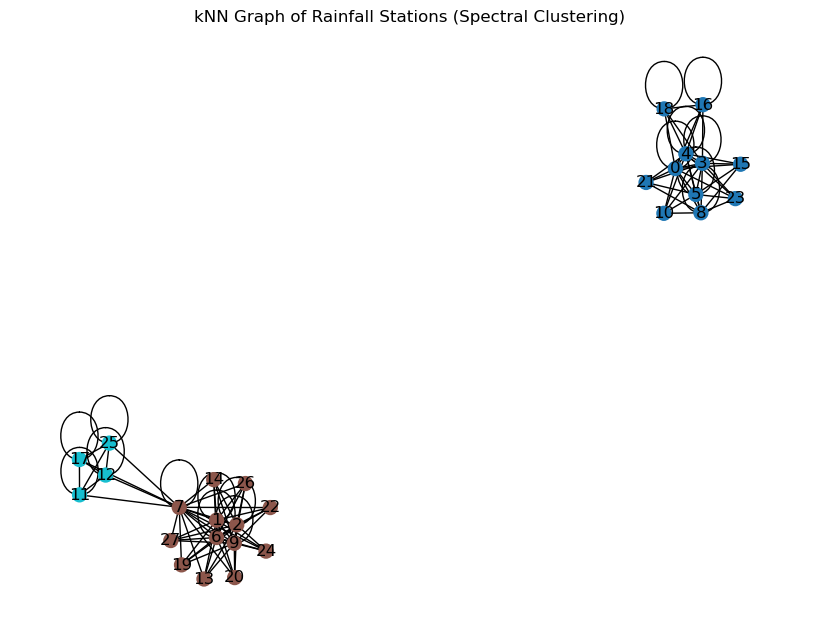

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

# Build graph from affinity matrix
G = nx.from_numpy_array(affinity_matrix)

# Color nodes by cluster labels
plt.figure(figsize=(8, 6))
nx.draw_spring(G, node_color=labels, node_size=100, cmap="tab10", with_labels=True)
plt.title("kNN Graph of Rainfall Stations (Spectral Clustering)")
plt.show()


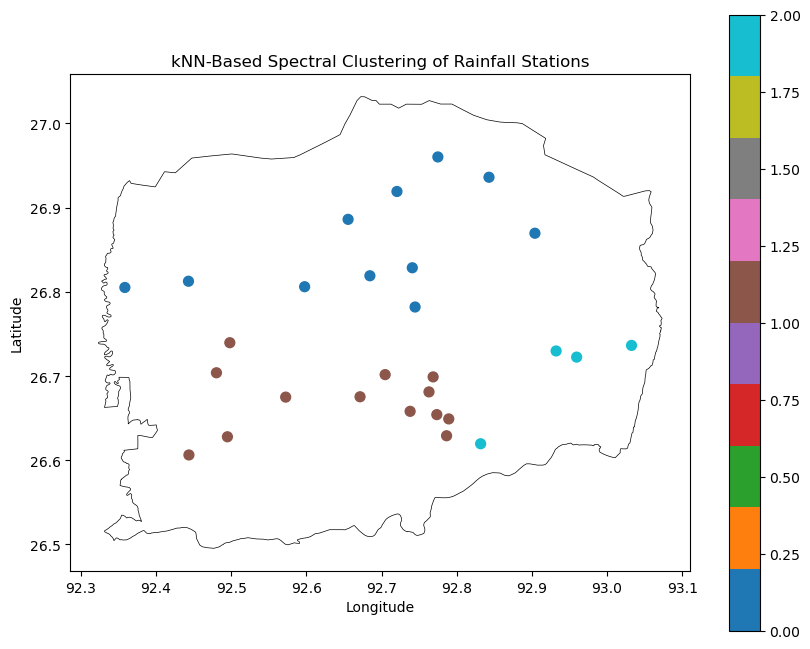

In [15]:
# Add location and label
result = pivoted.reset_index().merge(station_locations, on="STATION", how="left")
geometry = [Point(xy) for xy in zip(result["LONGITUDE"], result["LATITUDE"])]
gdf = gpd.GeoDataFrame(result, geometry=geometry, crs="EPSG:4326")

# Plot with district boundaries
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column="Cluster", cmap="tab10", legend=True, ax=ax, markersize=50)

# Add district shapefile
districts = gpd.read_file("Sonitpur + Biswanath merged/Sonitpur +.shp")
districts.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5)

plt.title("kNN-Based Spectral Clustering of Rainfall Stations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show() 


In [15]:
#result.to_csv('clusters_formed.csv')

In [15]:
# Degree of each node
degrees = dict(G.degree())
print("Degrees:", degrees)

# Cluster-wise analysis
for i in range(n_clusters):
    print(f"Cluster {i}:")
    print(result[result["Cluster"] == i]["STATION"].values)


Degrees: {0: 12, 1: 14, 2: 14, 3: 12, 4: 12, 5: 10, 6: 14, 7: 18, 8: 10, 9: 14, 10: 5, 11: 6, 12: 6, 13: 5, 14: 5, 15: 5, 16: 6, 17: 6, 18: 6, 19: 5, 20: 5, 21: 5, 22: 5, 23: 5, 24: 5, 25: 6, 26: 5, 27: 5}
Cluster 0:
['BALIPARA' 'BOGIBIL' 'CHARIA BIL' 'CHARIDUAR' 'GAMANI BANGAON'
 'HUGRAJULI' 'MISSAMARI' 'MORISUTI' 'NAMERI NP' 'RANGAPARA' 'SIRAJULI']
Cluster 1:
['BESSERIA' 'BIHAGURI' 'DEKARGAON' 'DHEKIAJULI' 'GHAGRA GAON'
 'KAMARCHUBURI' 'MAZGAON' 'NIZ BIHAGURI GAON' 'ORANG NP' 'SALONIBARI'
 'SITAL MARI' 'TEZPUR' 'THELAMARA']
Cluster 2:
['JAMUGURIHAT' 'KALIABHOMORA' 'NADUAR' 'SOOTEA']


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


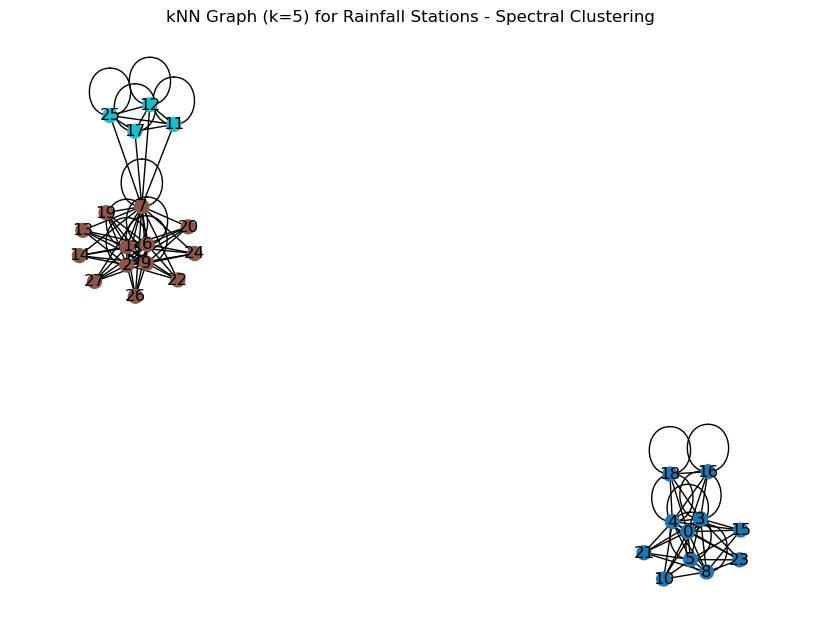

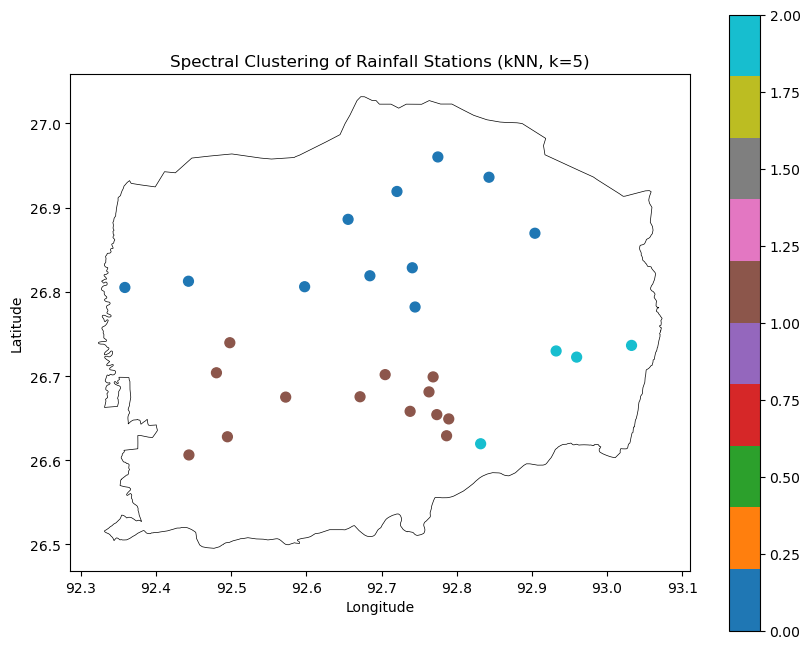


Cluster 0 stations: ['BALIPARA', 'BOGIBIL', 'CHARIA BIL', 'CHARIDUAR', 'GAMANI BANGAON', 'HUGRAJULI', 'MISSAMARI', 'MORISUTI', 'NAMERI NP', 'RANGAPARA', 'SIRAJULI']

Cluster 1 stations: ['BESSERIA', 'BIHAGURI', 'DEKARGAON', 'DHEKIAJULI', 'GHAGRA GAON', 'KAMARCHUBURI', 'MAZGAON', 'NIZ BIHAGURI GAON', 'ORANG NP', 'SALONIBARI', 'SITAL MARI', 'TEZPUR', 'THELAMARA']

Cluster 2 stations: ['JAMUGURIHAT', 'KALIABHOMORA', 'NADUAR', 'SOOTEA']


In [16]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import networkx as nx

# --- Step 1: Load the rainfall data ---
rainfall_df = pd.read_csv("rainfall_per_year.csv")

# Create pivot table: stations × years
pivoted = rainfall_df.pivot_table(
    index="STATION", 
    columns="Year", 
    values="Total_Rainfall", 
    fill_value=0
)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(pivoted)

# --- Step 2: Create kNN graph ---
k = 5  # Adjust as needed
knn_graph = kneighbors_graph(data_scaled, n_neighbors=k, mode='connectivity', include_self=True)
affinity_matrix = knn_graph.toarray()

# --- Step 3: Spectral Clustering on kNN graph ---
n_clusters = 3
clustering = SpectralClustering(
    n_clusters=n_clusters,
    affinity='precomputed',
    assign_labels='kmeans',
    random_state=0
)
labels = clustering.fit_predict(affinity_matrix)

# Add cluster labels
pivoted["Cluster"] = labels

# --- Step 4: Add coordinates back ---
station_locations = rainfall_df.drop_duplicates("STATION")[["STATION", "LATITUDE", "LONGITUDE"]]
result = pivoted.reset_index().merge(station_locations, on="STATION", how="left")

# --- Step 5: Visualize kNN Graph ---
G = nx.from_numpy_array(affinity_matrix)

plt.figure(figsize=(8, 6))
nx.draw_spring(G, node_color=labels, node_size=100, cmap="tab10", with_labels=True)
plt.title(f"kNN Graph (k={k}) for Rainfall Stations - Spectral Clustering")
plt.show()

# --- Step 6: Geographical Visualization ---
geometry = [Point(xy) for xy in zip(result["LONGITUDE"], result["LATITUDE"])]
gdf = gpd.GeoDataFrame(result, geometry=geometry, crs="EPSG:4326")

# Read district boundaries
districts = gpd.read_file("Sonitpur + Biswanath merged/Sonitpur +.shp")

# Plot clusters on map
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column="Cluster", cmap="tab10", legend=True, ax=ax, markersize=50)
districts.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5)

plt.title(f"Spectral Clustering of Rainfall Stations (kNN, k={k})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# --- Step 7: Export results ---
result.to_csv("knn_spectral_clusters.csv", index=False)

# --- Optional: Print clusters ---
for i in range(n_clusters):
    stations = result[result["Cluster"] == i]["STATION"].tolist()
    print(f"\nCluster {i} stations: {stations}")


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



=== k = 3 ===


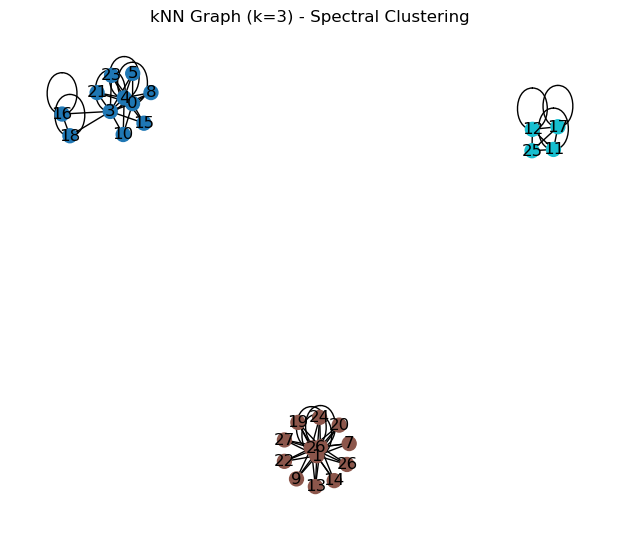

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



=== k = 5 ===


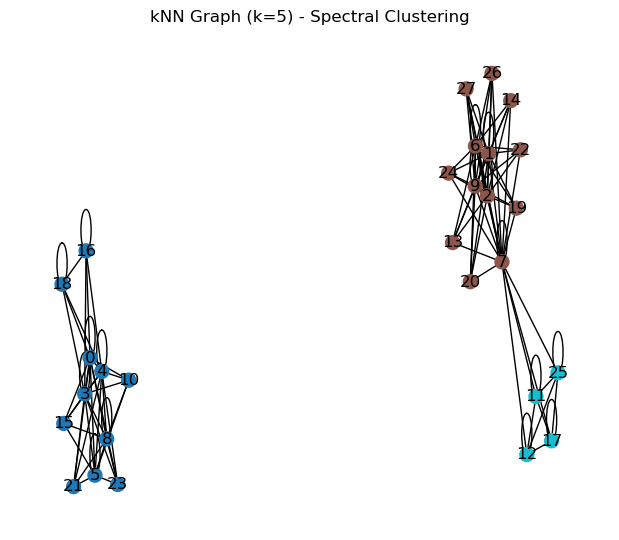

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



=== k = 7 ===


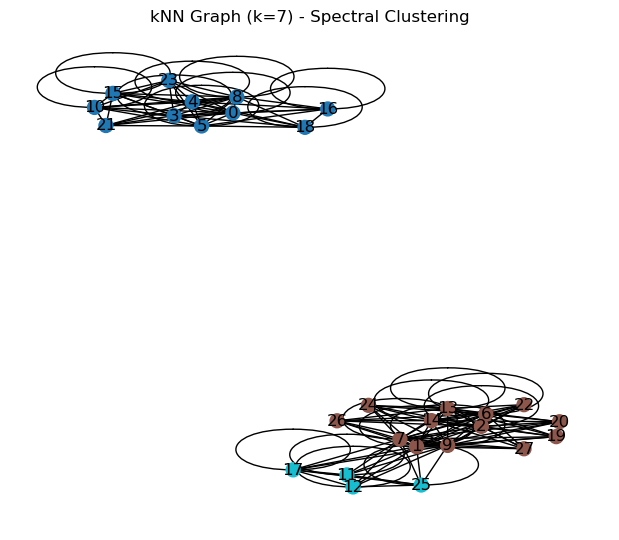

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



=== k = 10 ===


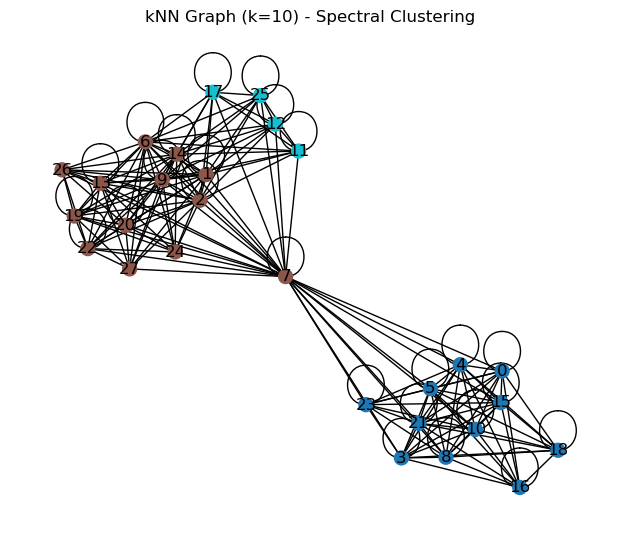

In [18]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load rainfall data (pivoted + scaled)
rainfall_df = pd.read_csv("rainfall_per_year.csv")
pivoted = rainfall_df.pivot_table(index="STATION", columns="Year", values="Total_Rainfall", fill_value=0)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(pivoted)

# Station info
station_locations = rainfall_df.drop_duplicates("STATION")[["STATION", "LATITUDE", "LONGITUDE"]]

# Try different values of k
for k in [3, 5, 7, 10]:
    knn_graph = kneighbors_graph(data_scaled, n_neighbors=k, mode='connectivity', include_self=True)
    affinity_matrix = knn_graph.toarray()

    clustering = SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='kmeans', random_state=0)
    labels = clustering.fit_predict(affinity_matrix)

    print(f"\n=== k = {k} ===")
    
    # Graph visualization
    G = nx.from_numpy_array(affinity_matrix)
    plt.figure(figsize=(6, 5))
    nx.draw_spring(G, node_color=labels, node_size=100, cmap="tab10", with_labels=True)
    plt.title(f"kNN Graph (k={k}) - Spectral Clustering")
    plt.show()

    # Add clusters to stations
    pivoted["Cluster"] = labels
    result = pivoted.reset_index().merge(station_locations, on="STATION", how="left")

    # Save or store results if needed
    result.to_csv(f"spectral_k{k}_clusters.csv", index=False)


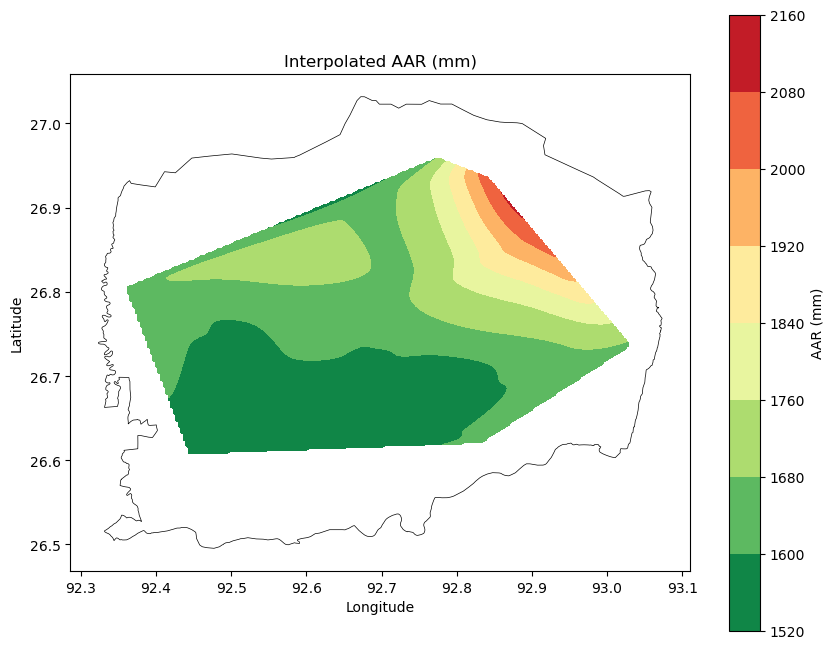

In [18]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from shapely.geometry import Point

# Station data: LATITUDE, LONGITUDE, AAR
stations = pd.read_csv("avg_clusters.csv")

# Create coordinate and value arrays
points = stations[['LONGITUDE', 'LATITUDE']].values
values = stations['Average Annual Rainfall'].values

# Create grid
grid_x, grid_y = np.mgrid[
    stations['LONGITUDE'].min():stations['LONGITUDE'].max():200j,
    stations['LATITUDE'].min():stations['LATITUDE'].max():200j
]

# Interpolate AAR over the grid
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

# Plot interpolation
fig, ax = plt.subplots(figsize=(10, 8))
cs = ax.contourf(grid_x, grid_y, grid_z, cmap='RdYlGn_r')
plt.colorbar(cs, ax=ax, label='AAR (mm)')

# Overlay shapefile
districts = gpd.read_file("Sonitpur + Biswanath merged\Sonitpur +.shp")
districts.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)

ax.set_title('Interpolated AAR (mm)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_7844\1863054686.py:33: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  district_path = Path(districts.unary_union.exterior.coords)


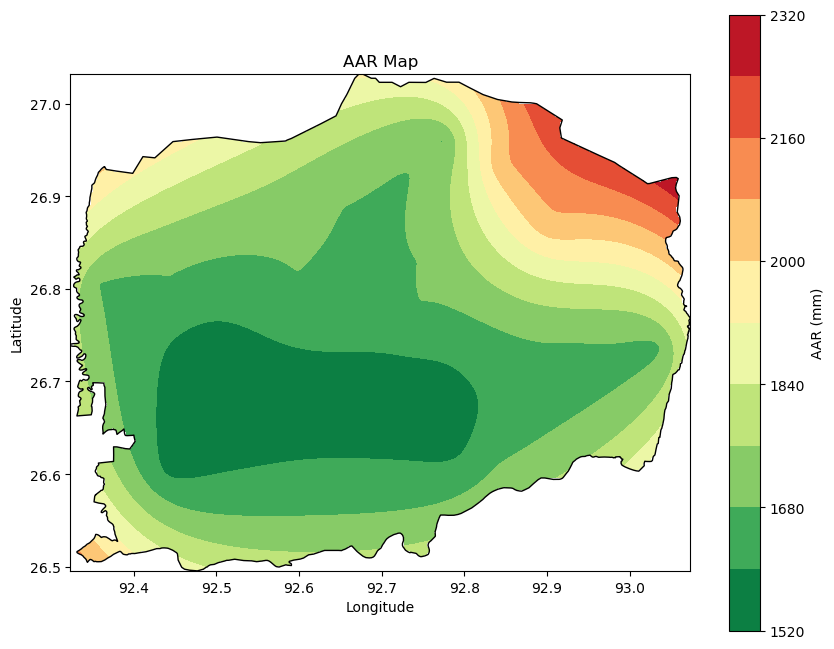

In [34]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
from shapely.geometry import Point

# Load your station data (with AAR values)
df = pd.read_csv("avg_clusters.csv")  # Ensure it has LATITUDE, LONGITUDE, AAR

# Load district shapefile
districts = gpd.read_file("Sonitpur + Biswanath merged/Sonitpur +.shp")
districts = districts.to_crs("EPSG:4326")

# Extract coordinates and values
x = df["LONGITUDE"].values
y = df["LATITUDE"].values
z = df["Average Annual Rainfall"].values  # Replace with actual AAR column name

# Define grid over entire district bounding box
minx, miny, maxx, maxy = districts.total_bounds
grid_x, grid_y = np.meshgrid(
    np.linspace(minx, maxx, 300),
    np.linspace(miny, maxy, 300)
)

# Use Radial Basis Function interpolation (with extrapolation)
rbf = Rbf(x, y, z, function='linear')  # You can try 'multiquadric', 'inverse', etc.
grid_z = rbf(grid_x, grid_y)

# Optional: mask to district shape
from matplotlib.path import Path
district_path = Path(districts.unary_union.exterior.coords)
mask = ~district_path.contains_points(np.c_[grid_x.ravel(), grid_y.ravel()])
grid_z = np.ma.array(grid_z, mask=mask.reshape(grid_z.shape))

# Plot the result
plt.figure(figsize=(10, 8))
contour = plt.contourf(grid_x, grid_y, grid_z, cmap="RdYlGn_r", levels=10)
plt.colorbar(contour, label="AAR (mm)")
districts.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
plt.title("AAR Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [30]:
# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f} mm")


Mean Absolute Error: 63.13 mm
